In [1]:
import glob
import importlib
import random
import sys
from itertools import combinations

import matplotlib as mpl
import matplotlib.pyplot as plt
import MDAnalysis as mda
import mdtraj as md
import numpy as np
import prettypyplot as pplt
import pyemma
import seaborn as sns
from matplotlib import ticker

import extq
import ivac

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


In [2]:
sys.path.insert(1, "../../python")
import plotting
import util

In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

# CV definitions taken from Delemotte, PNAS 2015

For each arginine $R_i$ we have
$$CV_{R_i} = B(S_f) - B(S_i) + \kappa x$$
where $S_f$ and $S_i$ are the starting and initial "groups" for the transition of interest. 
<!-- In our case, these are generally going to be the negatively charged residues (either E183/D186 or D129), and e.g. for the down -> up transition we will consider $CV_{R229}$ with $S_f$ as D129 and $S_i$ as E183/D186. -->

The binding values are computed as a generalized logistic function
$$B(S) = (1 + a\exp[-b(S - c)])^{-1}$$
with the binding function at the given group defined by
$$S = \sum_i\sum_j\exp[-(r_{ij} - d_0)^2 / 2r_0^2]$$
where $i,j$ are atoms from the positively charged (arginine) and negatively charged groups, respectively, $d_0$ and $r_0$ are equilibrium averages and deviations.
The parameters $a,b,c$ are fit to equilibrium distributions of groups, such as the distance for binding at half-maximum. "The fitting function is used to describe the binding in a quasi-binary fashion (a group is either bound or unbound irrespective of the number of binding partners)"

We consider R226 and R229 here. For R226, the groups which define $S$ are the guanidinium, and the carboxylate of D186 (initial) or D129 (final). For R229, we also used guanidinium, but D186/E183 (initial), and D186 (final)

In [5]:
HOME_DIR = "/project/dinner/scguo/ci-vsd"
topfile = f"{HOME_DIR}/civsd-nowat.pdb"
u = mda.Universe(topfile, "../../anton2/nowat/civsd.nowat.3.dcd")

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


In [10]:
for a in u.select_atoms(f"protein and resid 129 and name CG OD1 OD2"):
    print(a)

<Atom 412: CG of type C of resname ASP, resid 129 and segid A and altLoc >
<Atom 413: OD1 of type O of resname ASP, resid 129 and segid A and altLoc >
<Atom 414: OD2 of type O of resname ASP, resid 129 and segid A and altLoc >


In [12]:
traj = md.load("../../anton2/nowat/civsd.nowat.3.dcd", top=topfile)

In [15]:
traj.top.select("protein and residue 129 and name CG OD1 OD2")

array([411, 412, 413])

In [18]:
traj.top.select("protein and residue 226 and name NE NH1 NH2")

array([1945, 1948, 1951])

In [41]:
from itertools import product
from typing import NamedTuple

In [47]:
# for E/D, a = 0.46, b = 7.78, c = 0.82, d0 = 0.395 nm, r0 = 0.018 nm
# for phos, a = 0.51, b = 6.95, c = 0.32, d0 = 0.445 nm, r0 = 0.041 nm
class Params(NamedTuple):
    a: float
    b: float
    c: float
    d0: float
    r0: float


# ED_params = Params(
def compute_B(traj, r_sel, counter_sel, params):
    r_ids = traj.top.select(r_sel)
    counter_ids = traj.top.select(counter_sel)
    pair_ids = product(r_ids, counter_ids)
    
    # MDTraj uses nanometers by default
    dists = md.compute_distances(traj, pair_ids)
    S = np.exp(-((dists - params.d0) ** 2) / (2 * params.r0 ** 2))
    S = np.sum(S, axis=-1)
    B = (1 + params.a * np.exp(-params.b * (S - params.c))) ** (-1)
    return B

In [48]:
ED_params = Params(0.46, 7.78, 0.82, 0.395, 0.018)
phos_params = Params(0.51, 6.95, 0.32, 0.445, 0.041)

In [51]:
r226_sel = "protein and residue 226 and name NE NH1 NH2"
d129_sel = "protein and residue 129 and name CG OD1 OD2"
d186_sel = "protein and residue 186 and name CG OD1 OD2"
test1 = compute_B(traj, r226_sel, d129_sel, ED_params)
test2 = compute_B(traj, r226_sel, d186_sel, ED_params)
print(test1[:10] - test2[:10])

[0.9963229  0.9963106  0.9963249  0.99628675 0.99618554 0.996325
 0.9962362  0.9963219  0.99508536 0.9962969 ]


In [28]:
traj.top.select(
    "protein and (residue 186 and name CG OD1 OD2) or (residue 183 and name CD OE1 OE2)"
)

array([1266, 1267, 1268, 1304, 1305, 1306])

In [61]:
r229_sel = "protein and residue 229 and name NE NH1 NH2"
init_sel = "protein and (residue 183 and name CD OE1 OE2)"
final_sel = "protein and residue 186 and name CG OD1 OD2"
test1 = compute_B(traj, r229_sel, final_sel, ED_params)
test2 = compute_B(traj, r229_sel, init_sel, ED_params)
print(test1[-10:] - test2[-10:])

[0.92426866 0.03301328 0.99583185 0.9814934  0.82684594 0.69812006
 0.8306838  0.96604466 0.9887019  0.9944391 ]


In [62]:
r232_sel = "protein and residue 232 and name NE NH1 NH2"
de_sel = (
    "protein and (residue 186 and name CG OD1 OD2) or (residue 183 and name CD OE1 OE2)"
)
phos_sel = "resname POPC and name P O11 O12 O13 O14"
# print(traj.top.select(phos_sel))
test1 = compute_B(traj, r232_sel, de_sel, ED_params)
test2 = compute_B(traj, r232_sel, phos_sel, phos_params)
print(test1[:10] - test2[:10])

[-1.6837575e-01  1.2329146e-01 -3.5094482e-01  2.2568107e-02
 -4.5556605e-02  6.7395020e-01  2.5573999e-01 -9.9837780e-05
  1.2609655e-01  3.9264426e-01]


# Production calculations

In [76]:
from multiprocessing import cpu_count

from joblib import Parallel, delayed

n_jobs = 32

In [106]:
r226_sel = "protein and residue 226 and name NE NH1 NH2"
r229_sel = "protein and residue 229 and name NE NH1 NH2"
r232_sel = "protein and residue 232 and name NE NH1 NH2"
d129_sel = "protein and residue 129 and name CG OD1 OD2"
d186_sel = "protein and residue 186 and name CG OD1 OD2"
e183_sel = "protein and residue 183 and name CD OE1 OE2"
de_sel = (
    "protein and (residue 186 and name CG OD1 OD2) or (residue 183 and name CD OE1 OE2)"
)
phos_sel = "resname POPC and name P O11 O12 O13 O14"


def run_analysis(trajfile):
    traj = md.load(trajfile, top=topfile)
    # R226
    r226_init = compute_B(traj, r226_sel, d186_sel, ED_params)
    r226_fin = compute_B(traj, r226_sel, d129_sel, ED_params)
    # R229
    r229_init = compute_B(traj, r229_sel, e183_sel, ED_params)
    r229_fin = compute_B(traj, r229_sel, d186_sel, ED_params)
    # R232
    r232_init = compute_B(traj, r232_sel, phos_sel, phos_params)
    r232_fin = compute_B(traj, r232_sel, de_sel, ED_params)

    return np.vstack(
        ((r226_fin - r226_init), (r229_fin - r229_init), (r232_fin - r232_init))
    )

In [64]:
anton2 = []
for i in range(3, 119):
    if i == 82:
        continue
    anton2.append(f"{HOME_DIR}/anton2/nowat/civsd.nowat.{i}.dcd")
print(len(anton2))

115


In [107]:
ans = run_analysis(anton2[0])

In [108]:
ans.shape

(3, 10001)

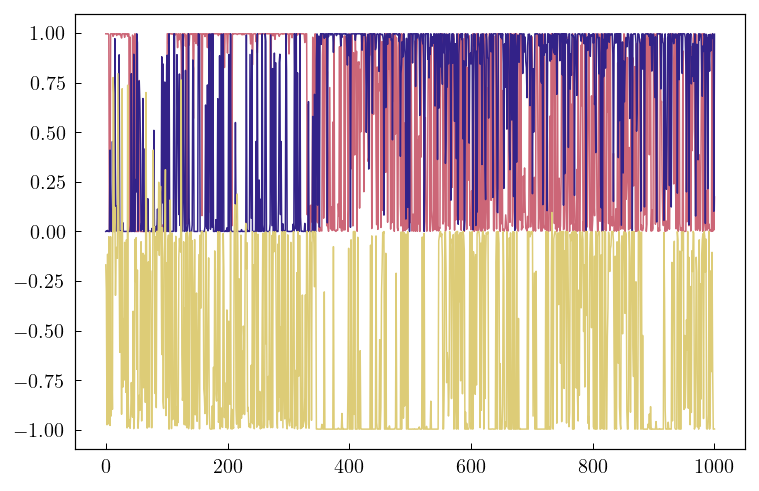

In [73]:
for i in range(3):
    # plt.plot(util.smooth_moving_average(ans[:, i], 10))
    plt.plot(ans[::10, i])

In [109]:
results = Parallel(n_jobs=n_jobs, verbose=20, backend='multiprocessing')(
    delayed(run_analysis)(file) for file in anton2
)

[Parallel(n_jobs=32)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 tasks      | elapsed:   11.6s
[Parallel(n_jobs=32)]: Done   2 tasks      | elapsed:   18.2s
[Parallel(n_jobs=32)]: Done   3 tasks      | elapsed:   18.4s
[Parallel(n_jobs=32)]: Done   4 tasks      | elapsed:   18.9s
[Parallel(n_jobs=32)]: Done   5 tasks      | elapsed:   18.9s
[Parallel(n_jobs=32)]: Done   6 tasks      | elapsed:   19.8s
[Parallel(n_jobs=32)]: Done   7 tasks      | elapsed:   19.8s
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:   19.9s
[Parallel(n_jobs=32)]: Done   9 tasks      | elapsed:   20.2s
[Parallel(n_jobs=32)]: Done  10 tasks      | elapsed:   20.3s
[Parallel(n_jobs=32)]: Done  11 tasks      | elapsed:   20.3s
[Parallel(n_jobs=32)]: Done  12 tasks      | elapsed:   20.4s
[Parallel(n_jobs=32)]: Done  13 tasks      | elapsed:   20.4s
[Parallel(n_jobs=32)]: Done  14 tasks      | elapsed:   20.5s
[Parallel(n_jobs=32)]: Done  15 tasks      |

In [110]:
for i in results:
    print(i.shape)

(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)
(3, 10001)

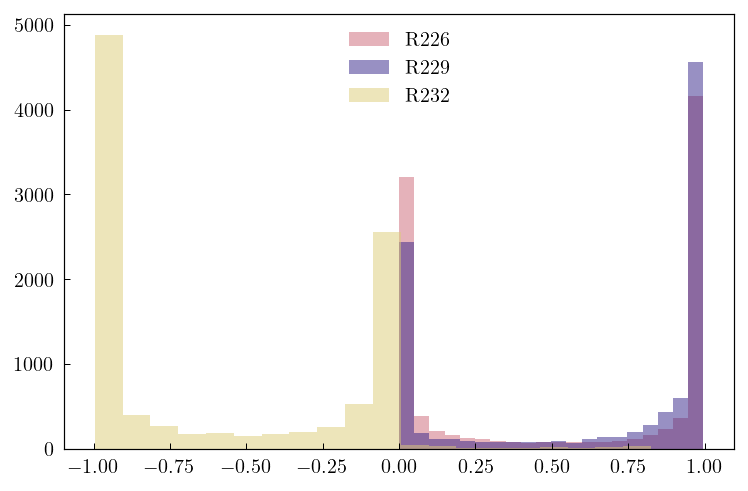

In [111]:
for i in range(3):
    plt.hist(np.concatenate(results)[i, :], bins=20, alpha=0.5)
plt.legend(['R226', 'R229', 'R232'])

In [112]:
np.save("../../data/raw_feat/delemotte_cvs_r234_anton2", results)

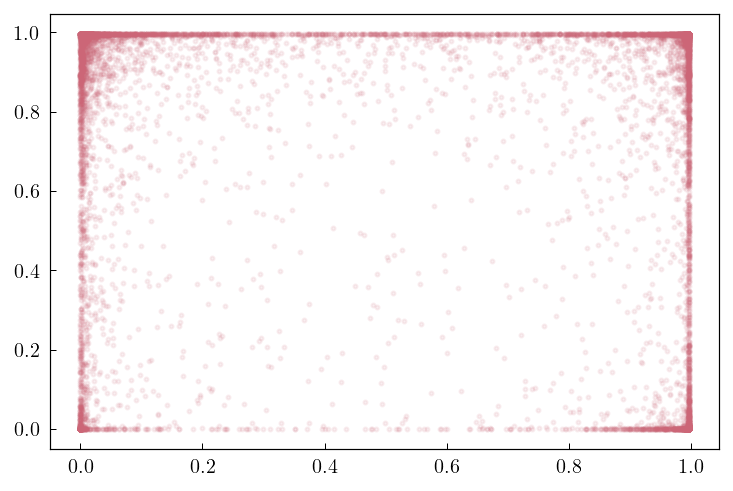

In [114]:
data = np.concatenate(results)
plt.scatter(data[0, :], data[1, :], alpha=0.1)

In [130]:
pdb_up = md.load("../../civsd-nowat.pdb")
pdb_down = md.load("../../models/MD-clustering-center/civsd-down-gc.pdb")
pdb_down.superpose(pdb_up, atom_indices=pdb_down.top.select("protein"))

<mdtraj.Trajectory with 1 frames, 56582 atoms, 10692 residues, and unitcells at 0x7f21ca8b1e20>

In [134]:
r229_diffvec = np.mean(pdb_up.xyz[0, pdb_up.top.select(d129_sel)] - pdb_up.xyz[0, pdb_up.top.select(d186_sel)], axis=0)
r229_diffvec_down = np.mean(pdb_down.xyz[0, pdb_down.top.select(d129_sel)] - pdb_down.xyz[0, pdb_down.top.select(d186_sel)], axis=0)
r229_diffvec_mix = np.mean(pdb_up.xyz[0, pdb_up.top.select(d129_sel)] - pdb_down.xyz[0, pdb_down.top.select(d186_sel)], axis=0)
print(r229_diffvec)
print(r229_diffvec_down)
print(r229_diffvec_mix)

[-0.8070666  0.6420333  1.0704333]
[-0.45479593  0.60359067  0.96868443]
[-0.4035145   0.49773297  1.0733981 ]
